# **프로젝트 : CutMix 또는 Mixup 비교실험 하기**
---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

os.chdir('/content/drive/MyDrive/AIFFEL/GoingDeeper/GD04')

In [3]:
os.getcwd()

'/content/drive/MyDrive/AIFFEL/GoingDeeper/GD04'

***주요 라이브러리 버전 확인***

In [4]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.8.2
1.21.6


<br>

## **(1) 데이터 불러오기**
---

In [5]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [6]:
# 학습전 GPU 환경 확인하기
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteWDXLRC/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteWDXLRC/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


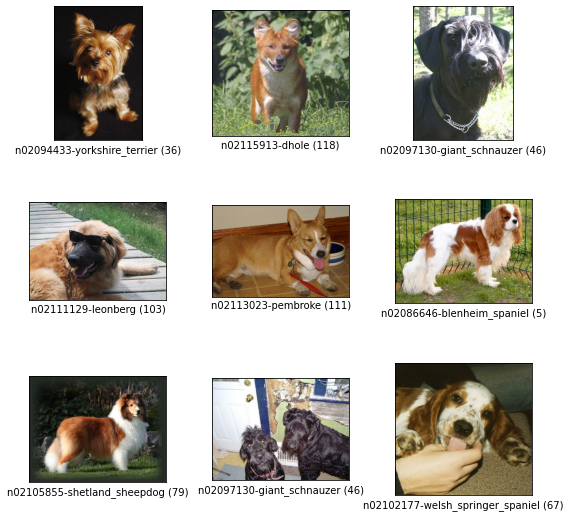

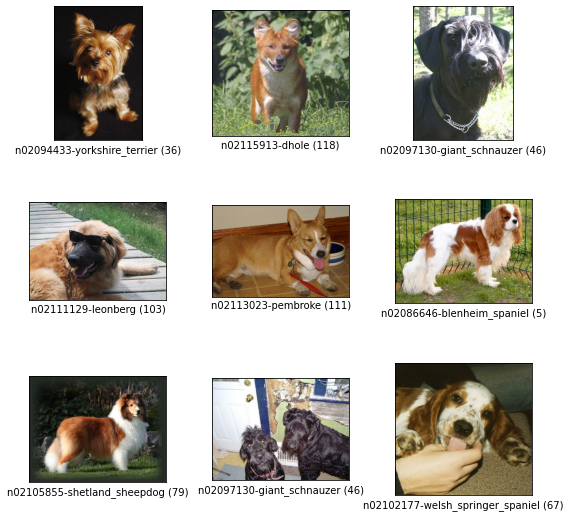

In [8]:
tfds.show_examples(ds_train, ds_info)

<br>

## **(2) Augmentation을 적용한 데이터셋 만들기**
---

***텐서플로우 Random Augmentation API 사용하기***
<br>
- `random_brightness()`
- `random_contrast()`
- `random_crop()`
- `random_flip_left_right()`
- `random_flip_up_down()`
- `random_hue()`
- `random_jpeg_quality()`
- `random_saturation()`

In [9]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [10]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
#     image = tf.image.random_crop(image, size=())
#     image = tf.image.
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [11]:
# # make random augment function
# def augment_mine(image,label):
#     image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
#     image = tf.image.resize(image, [224, 224])
#     return image, label

In [12]:
# def onehot(image, label):
#     label = tf.one_hot(label, num_classes)
#     return image, label

<br>

### 심화 기법 (1) Cutmix Augmentation
---

#### 1) 이미지 섞기
---

In [13]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)
    
    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [14]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_a의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :] # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_a의 오른쪽 바깥 영역
    middle = tf.concat([middle_left, middle_center, middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom], axis=0)
    
    return mixed_img

<br>

#### 2) 라벨 섞기
---

- `CutMix`에서는 면적에 비례해서 라벨을 섞어준다. 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두가지 라벨의 비율로 더해준다.

In [15]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_a, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

<br>

#### 3) CutMix 함수
---

In [16]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_a))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

<br>

### 심화 기법 (2) Mixup Augmentation
---

In [17]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.cast(tf.random.uniform([], 0, 1), tf.float32)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

<br>

#### Mixup 함수
---

In [18]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

<br>

### 심화 기법 (3) One Hot 함수
---

In [19]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)
        
        onehot_imgs.append(image_a)
        onehot_labels.append(label_a)

    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels),(batch_size, num_classes))
    return onehot_imgs, onehot_labels

<br>

## **(3) 데이터셋(ds)을 가공하는 메인함수**

---


In [20]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, 
                               with_img=False, with_aug=False, 
                               with_cutmix=False, with_mixup=False,
                               one_hot=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup, 
            num_parallel_calls=2
        )
    if is_test and one_hot:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

<br>

## **(4) 모델 만들기**
### **1) ResNet-50 모델 불러오기**

---

-  텐서플로우 케라스의 ResNet50 중 imagenet으로 훈련된 모델을 불러옵니다. include_top은 마지막 fully connected layer를 포함할지 여부입니다. 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있습니다. 이렇게 하는 이유는 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문입니다.

In [21]:
num_classes = ds_info.features["label"].num_classes

# 1 데이터셋으로 학습시킬 ResNet
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [22]:
# 2 Augmentation을 적용한 데이터셋으로 학습시킬 ResNet
resnet50_with_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [23]:
# 3 Augmentation 및 CutMix를 적용한 데이터셋으로 학습시킬 ResNet
resnet50_with_aug_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [24]:
# 4 Augmentation 및 Mixup을 적용한 데이터셋으로 학습시킬 ResNet
resnet50_with_aug_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

<br>

### **2) `Stanford Dogs` 데이터 다시 불러오기**
---

In [25]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

<br>

- 텐서플로우 데이터셋에서 불러온 데이터에 하나는 apply_normalize_on_dataset()에서 with_aug를 False로 주어 augmentation이 적용되지 않도록 하고, 다른 하나는 True로 주어 augmentation이 적용되도록 합니다.


In [26]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test_no = apply_normalize_on_dataset(ds_test, is_test = True)
ds_test_one = apply_normalize_on_dataset(ds_test, one_hot=True, is_test = True)

In [27]:
print(ds_train_no_aug)
print(ds_train_aug)
print(ds_train_aug_cutmix)
print(ds_train_aug_mixup)
print(ds_test_no)
print(ds_test_one)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 120), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 120), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 120), dtype=tf.float32, name=None))>


<br>

## **(5) 함수 동작 확인**
---

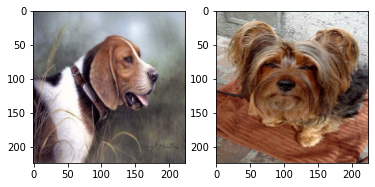

In [28]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져온다.
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i==0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(121)
plt.imshow(image_a)

plt.subplot(122)
plt.imshow(image_b)

### **Mixup 확인**
---


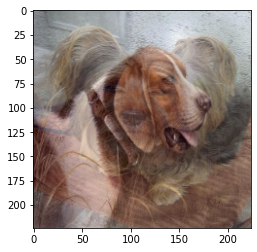

In [39]:
mixed_image, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_image.numpy())

In [40]:
mixed_label


<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.5635166 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.43648338, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

### **CutMix 확인**
---


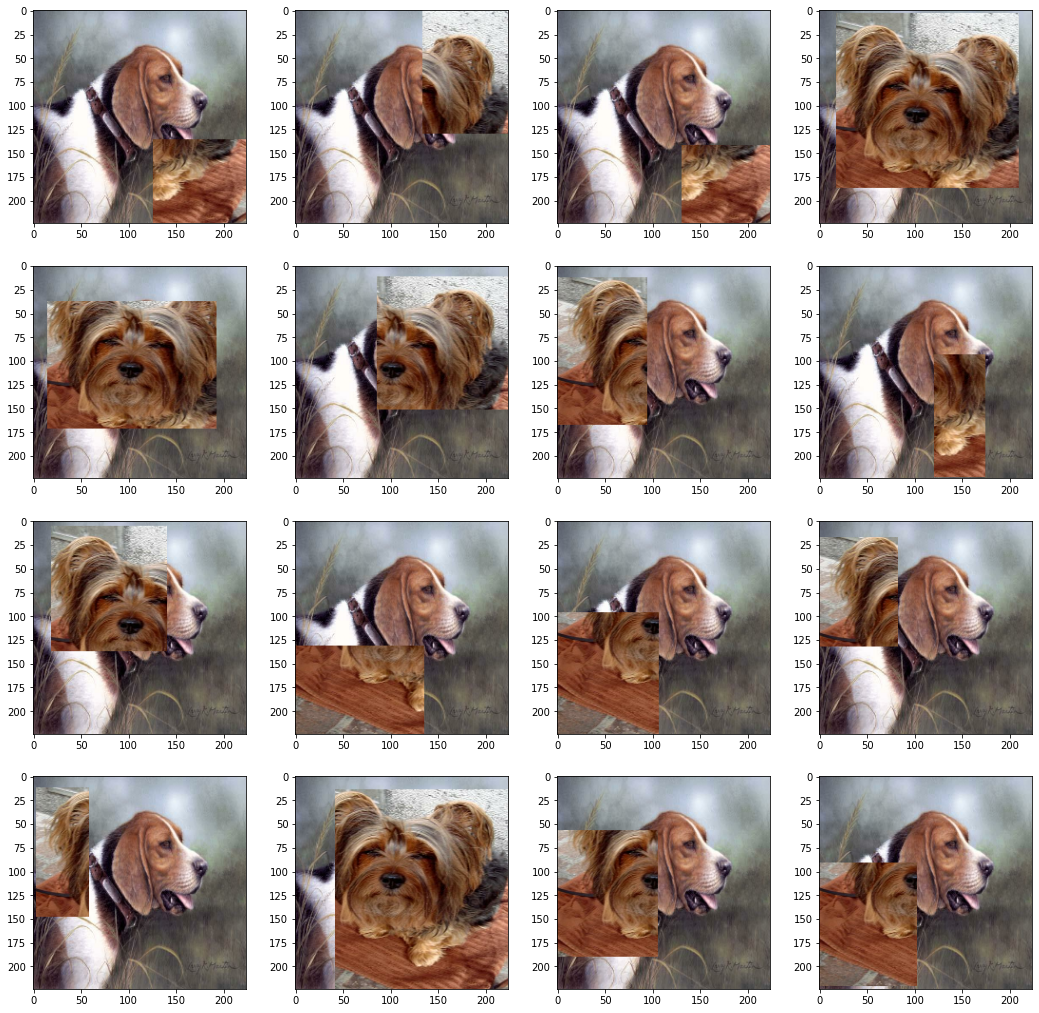

In [31]:
plt.figure(figsize=(18,18))
for i in range(16):
    plt.subplot(4, 4, i+1)
    xa, ya, xb, yb = get_clip_box(image_a, image_b)
    mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
    plt.imshow(mixed_img.numpy())

In [56]:
mixed_label = mix_2_labels(label_a, label_b, xa, ya, xb, yb, image_a)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.73313934, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.26686066, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

<br>

## **(6) 모델 훈련하기**
---

In [33]:
tf.random.set_seed(2020)

In [34]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

In [35]:
resnet50_no_aug.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_with_aug.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_with_aug_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_with_aug_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 164s 205ms/step - loss: 2.1966 - accuracy: 0.4487 - val_loss: 3.0082 - val_accuracy: 0.2722
Epoch 2/20
750/750 [==============================] - 152s 203ms/step - loss: 0.6862 - accuracy: 0.8148 - val_loss: 1.2016 - val_accuracy: 0.6462
Epoch 3/20
750/750 [==============================] - 152s 203ms/step - loss: 0.1795 - accuracy: 0.9673 - val_loss: 0.9352 - val_accuracy: 0.7267
Epoch 4/20
750/750 [==============================] - 152s 203ms/step - loss: 0.0491 - accuracy: 0.9969 - val_loss: 0.9864 - val_accuracy: 0.7197
Epoch 5/20
750/750 [==============================] - 152s 203ms/step - loss: 0.0512 - accuracy: 0.9951 - val_loss: 0.9669 - val_accuracy: 0.7266
Epoch 6/20
750/750 [==============================] - 152s 203ms/step - loss: 0.0180 - accuracy: 0.9992 - val_loss: 0.9454 - val_accuracy: 0.7348
Epoch 7/20
750/750 [==============================] - 167s 223ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.9595 -

In [ ]:
history_resnet50_aug = resnet50_with_aug.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 157s 203ms/step - loss: 0.1622 - accuracy: 0.9672 - val_loss: 0.9658 - val_accuracy: 0.7238
Epoch 2/20
750/750 [==============================] - 168s 224ms/step - loss: 0.1028 - accuracy: 0.9817 - val_loss: 0.9622 - val_accuracy: 0.7297
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0563 - accuracy: 0.9926 - val_loss: 1.0223 - val_accuracy: 0.7183
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0378 - accuracy: 0.9953 - val_loss: 0.9601 - val_accuracy: 0.7378
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0235 - accuracy: 0.9984 - val_loss: 0.9363 - val_accuracy: 0.7473
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0163 - accuracy: 0.9992 - val_loss: 0.9488 - val_accuracy: 0.7473
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0126 - accuracy: 0.9994 - val_loss: 0.9413 -

In [ ]:
history_resnet50_cutmix = resnet50_with_aug_cutmix.fit(
    ds_train_aug_cutmix , 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_one,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 163s 207ms/step - loss: 3.8334 - accuracy: 0.2186 - val_loss: 3.7348 - val_accuracy: 0.1566
Epoch 2/20
750/750 [==============================] - 156s 209ms/step - loss: 2.9487 - accuracy: 0.4345 - val_loss: 1.3541 - val_accuracy: 0.6178
Epoch 3/20
750/750 [==============================] - 156s 208ms/step - loss: 2.6200 - accuracy: 0.5341 - val_loss: 1.3242 - val_accuracy: 0.6348
Epoch 4/20
750/750 [==============================] - 170s 227ms/step - loss: 2.3998 - accuracy: 0.6091 - val_loss: 1.3180 - val_accuracy: 0.6354
Epoch 5/20
750/750 [==============================] - 156s 208ms/step - loss: 2.2587 - accuracy: 0.6551 - val_loss: 1.2013 - val_accuracy: 0.6648
Epoch 6/20
750/750 [==============================] - 157s 209ms/step - loss: 2.1555 - accuracy: 0.6877 - val_loss: 1.2835 - val_accuracy: 0.6583
Epoch 7/20
750/750 [==============================] - 156s 209ms/step - loss: 2.0479 - accuracy: 0.7169 - val_loss: 1.3014 -

In [41]:
history_resnet50_mixup = resnet50_with_aug_mixup.fit(
    ds_train_aug_mixup , 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_one,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 177s 210ms/step - loss: 3.7079 - accuracy: 0.2457 - val_loss: 4.3667 - val_accuracy: 0.0880
Epoch 2/20
750/750 [==============================] - 164s 219ms/step - loss: 2.8596 - accuracy: 0.4735 - val_loss: 1.5430 - val_accuracy: 0.5799
Epoch 3/20
750/750 [==============================] - 165s 220ms/step - loss: 2.5523 - accuracy: 0.5907 - val_loss: 1.3407 - val_accuracy: 0.6222
Epoch 4/20
750/750 [==============================] - 165s 220ms/step - loss: 2.3749 - accuracy: 0.6532 - val_loss: 1.2744 - val_accuracy: 0.6473
Epoch 5/20
750/750 [==============================] - 165s 220ms/step - loss: 2.2426 - accuracy: 0.7109 - val_loss: 1.3954 - val_accuracy: 0.6312
Epoch 6/20
750/750 [==============================] - 165s 220ms/step - loss: 2.1497 - accuracy: 0.7545 - val_loss: 1.2790 - val_accuracy: 0.6501
Epoch 7/20
750/750 [==============================] - 165s 220ms/step - loss: 2.0554 - accuracy: 0.7775 - val_loss: 1.1850 -

<br>

## **(7) 변수 저장**

---

In [42]:
import pickle

with open('history_resnet50_no_aug.pkl', 'wb') as f:
    pickle.dump(history_resnet50_no_aug.history['val_accuracy'], f)

with open('history_resnet50_aug.pkl', 'wb') as f:
    pickle.dump(history_resnet50_aug.history['val_accuracy'], f)

with open('history_resnet50_cutmix.pkl', 'wb') as f:
    pickle.dump(history_resnet50_cutmix.history['val_accuracy'], f)

with open('history_resnet50_mixup.pkl', 'wb') as f:
    pickle.dump(history_resnet50_mixup.history['val_accuracy'], f)

In [50]:
import pickle

with open('history_resnet50_no_aug.pkl', 'rb') as f:
    val_acc_history_resnet50_no_aug = pickle.load(f)

with open('history_resnet50_aug.pkl', 'rb') as f:
    val_acc_history_resnet50_aug = pickle.load(f)

with open('history_resnet50_cutmix.pkl', 'rb') as f:
    val_acc_history_resnet50_cutmix = pickle.load(f)

with open('history_resnet50_mixup.pkl', 'rb') as f:
    val_acc_history_resnet50_mixup = pickle.load(f)

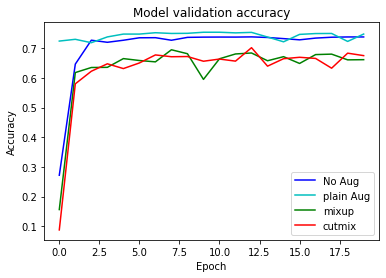

In [53]:
plt.plot(val_acc_history_resnet50_no_aug, 'b')
plt.plot(val_acc_history_resnet50_aug, 'c')
plt.plot(val_acc_history_resnet50_cutmix, 'g')
plt.plot(val_acc_history_resnet50_mixup, 'r')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'plain Aug' , 'mixup', 'cutmix'], loc='lower right')
plt.show()

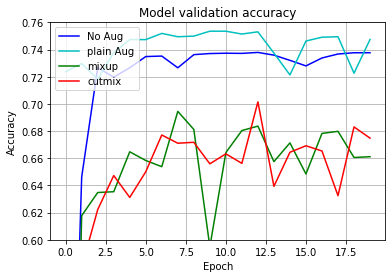

In [54]:
plt.plot(val_acc_history_resnet50_no_aug, 'b')
plt.plot(val_acc_history_resnet50_aug, 'c')
plt.plot(val_acc_history_resnet50_cutmix, 'g')
plt.plot(val_acc_history_resnet50_mixup, 'r')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'plain Aug' , 'mixup', 'cutmix'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.76)
plt.show()

<br>

## **(8) 결론**

---


- 이번 프로젝트에서는 keras의 Augmentation 방법 및 cutmix, mixup 알고리즘을 적용하여 기본 제공된 데이터를 증가시켜보았고 이를 학습하여 결론을 도출하였다. 


- ImageNet을 통해 미리 학습된 ResNet-50 모델을 적용하여 데이터 분류해보았다.


- 위의 표를 보게 되면 flip_lr 및 resize만 한 augmentation 데이터셋이 아무것도 하지 않은 no aug 모델보다 약간 더 높은 accuracy를 확보한 것에 반해 augmenation + CutMix && augmentation + Mixup을 섞은 모델들은 no aug 보다 accuaracy가 낮게 나타났다. 


- 이유를 짐작해보자면, Augmentation은 원본 데이터 이외에도 Augmentation을 통해 변형된 이미지를 추가시켜서 overfitting을 개선시키고 성능을 더 좋게 하기 위함이다. 하지만, 이번 프로젝트에서는 원본데이터를 같이 섞지 않고 변경된 데이터만 사용하였기 때문에 성능이 기본에 비해 낮게 나타난 것으로 보인다.  <<<  [github](https://github.com/PEBpung/Aiffel/blob/master/Project/Going%20Deeper/G4.%20CutMix%20or%20Mixup%20Comparison%20Experiment.ipynb) 내용을 참고하였다.